In [16]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from itertools import cycle

In [17]:
maindf=pd.read_csv('/content/BTC-USD.csv')

In [18]:
print('Total number of days present in the dataset: ',maindf.shape[0])
print('Total number of fields present in the dataset: ',maindf.shape[1])

Total number of days present in the dataset:  3352
Total number of fields present in the dataset:  7


In [19]:

maindf.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3352.000000,3352.000000,3352.000000,3352.000000,3352.000000,3.352000e+03
mean,14246.646767,14582.588818,13883.224861,14256.256182,14256.256182,1.647821e+10
std,16011.678239,16401.200905,15572.166782,16011.743768,16011.743768,1.917560e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,896.566025,910.066986,864.113754,898.162261,898.162261,1.470975e+08
50%,8160.602784,8288.145019,7928.415039,8164.351075,8164.351075,1.094857e+10
75%,23087.212402,23468.427246,22696.540039,23122.884766,23122.884766,2.695812e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [20]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

In [21]:
closedf = maindf[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (3352, 2)


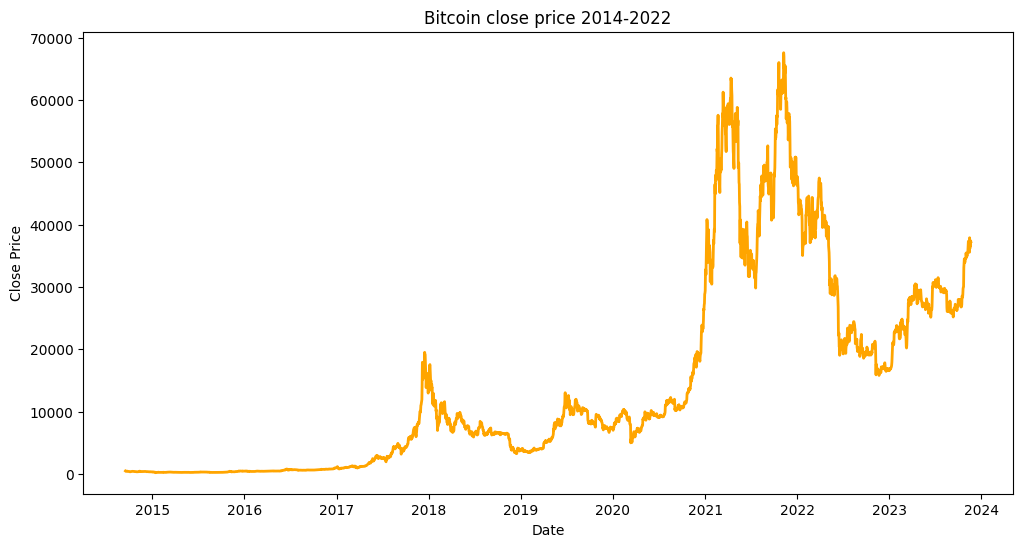

In [22]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.plot(closedf['Date'], closedf['Close'], color='orange', linewidth=2)
plt.title('Bitcoin close price 2014-2022')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [23]:
# trim to 1year of data
closedf = closedf[closedf['Date'] > '2022-11-20']
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  365


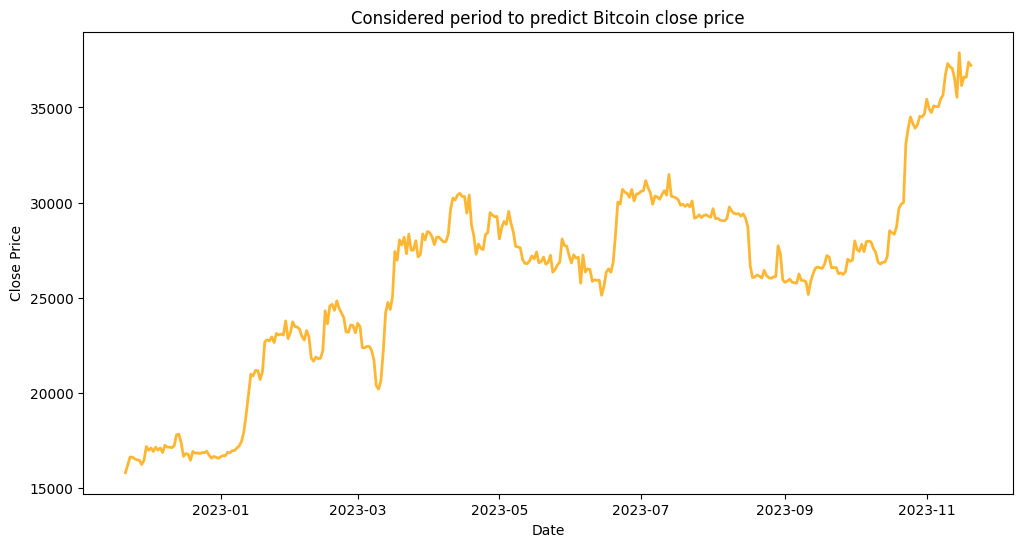

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(closedf['Date'], closedf['Close'], color='orange', linewidth=2, alpha=0.8)
plt.title('Considered period to predict Bitcoin close price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [25]:
!pip install prophet

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5k040t9f/gsigrna9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5k040t9f/mgxql2mh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70584', 'data', 'file=/tmp/tmp5k040t9f/gsigrna9.json', 'init=/tmp/tmp5k040t9f/mgxql2mh.json', 'output', 'file=/tmp/tmp5k040t9f/prophet_modeldxja8mvh/prophet_model-20231124091218.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:12:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:12:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


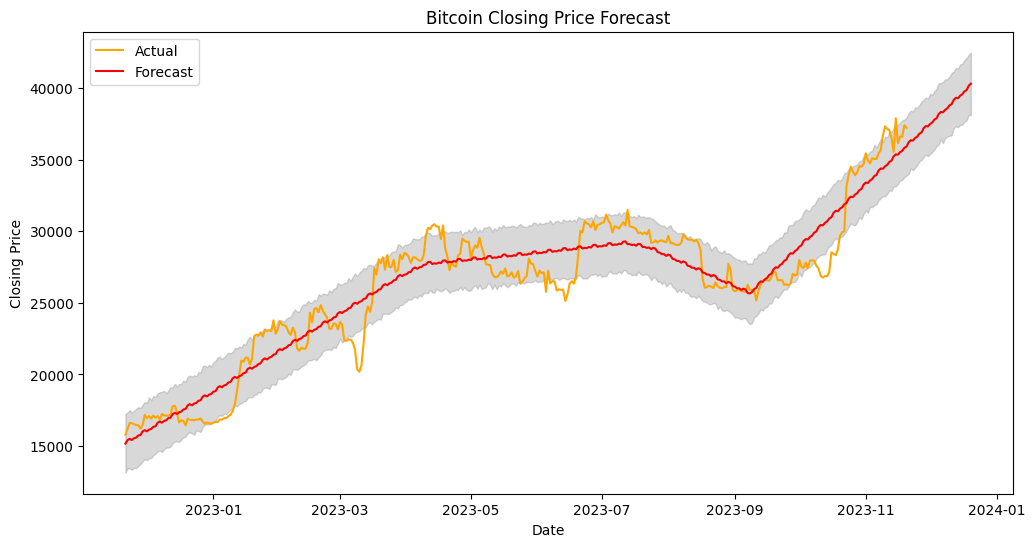

In [26]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, AutoDateFormatter

closedf.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)


model = Prophet()
model.fit(closedf)

# Create a dataframe for future predictions eg 30 days
future = model.make_future_dataframe(periods=30)

forecast = model.predict(future)

# plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(closedf['ds'], closedf['y'], label='Actual', color='orange', linestyle='-')
ax.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red', linestyle='-')
# uncertainty range
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.3)

ax.set_title('Bitcoin Closing Price Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price')
ax.legend()
plt.show()

In [33]:
from sklearn.metrics import r2_score
predicted = forecast.set_index('ds')['yhat'].loc[closedf['ds']]


forecasted_values = forecast.set_index('ds')['yhat'].loc[closedf['ds']]

# Calculate the model scores
r2 = r2_score(closedf['y'], predicted)
mse = mean_squared_error(closedf['y'], forecasted_values)
rmse = math.sqrt(mean_squared_error(closedf['y'], forecasted_values))
print("Root Mean Squared Error: ", rmse)
print("Mean Squared Error: ", mse)
print("R2 Score: ", r2)

Root Mean Squared Error:  1579.6653159785853
Mean Squared Error:  2495342.5105057238
R2 Score:  0.9015418767626449


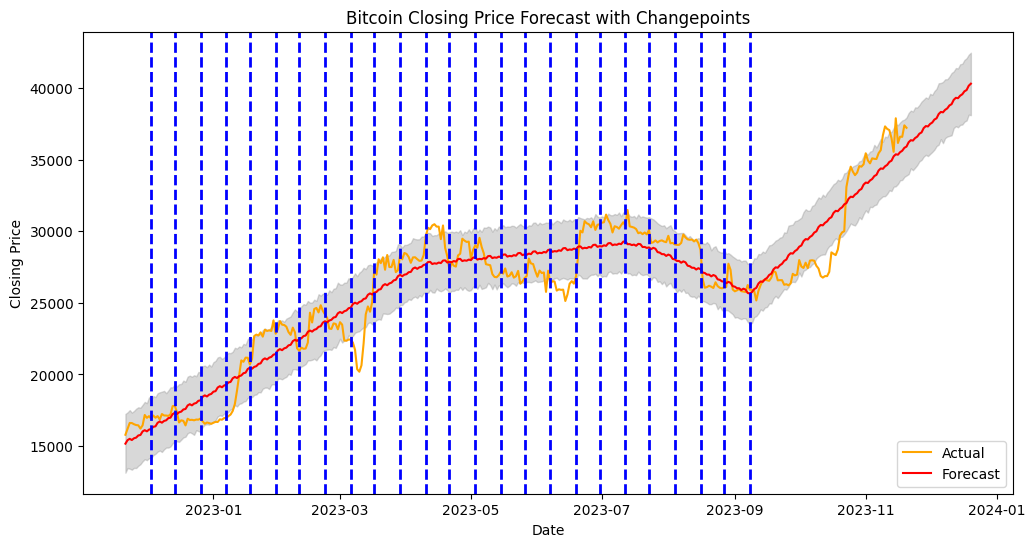

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(closedf['ds'], closedf['y'], label='Actual', color='orange', linestyle='-')
ax.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red', linestyle='-')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.3)
for changepoint in model.changepoints:
    plt.axvline(x=changepoint, color='blue', linestyle='--', lw=2)

ax.set_title('Bitcoin Closing Price Forecast with Changepoints')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price')
ax.legend()

plt.show()